# Debugging MXNet Gluon
## And other performance tricks

In [1]:
import multiprocessing
import time

import mxnet as mx
from mxnet import gluon, nd, autograd
import numpy as np
import random 
import mxboard as mxb

from skimage.transform import resize

In [2]:
mx.random.seed(42)
np.random.seed(42)
random.seed(42)

## 1) Visualizing Network

In [3]:
shape = (1, 3, 224, 224)

In [4]:
alexnet = gluon.model_zoo.vision.alexnet()
alexnet.initialize()

### Gluon layers description

In [5]:
print(alexnet)

AlexNet(
  (features): HybridSequential(
    (0): Conv2D(None -> 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (2): Conv2D(None -> 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (4): Conv2D(None -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2D(None -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Conv2D(None -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (8): Flatten
    (9): Dense(None -> 4096, Activation(relu))
    (10): Dropout(p = 0.5, axes=())
    (11): Dense(None -> 4096, Activation(relu))
    (12): Dropout(p = 0.5, axes=())
  )
  (output): Dense(None -> 1000, linear)
)


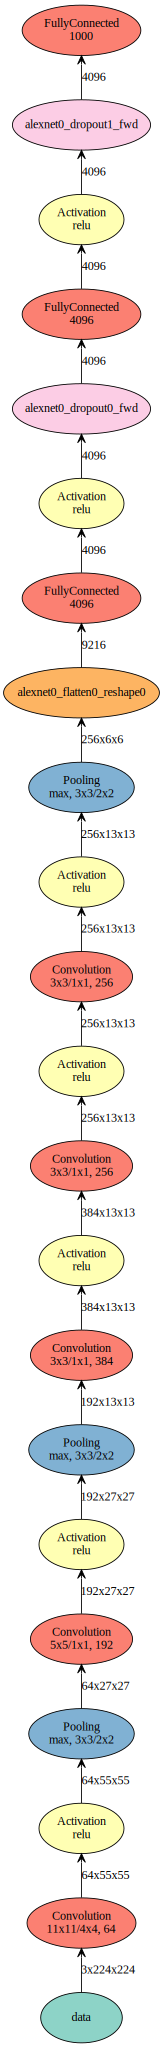

In [6]:
mx.viz.plot_network(
    alexnet(mx.sym.var('data')), 
    shape={'data':shape},
    node_attrs={"shape":"oval","fixedsize":"false"}
)

In [7]:
mx.viz.print_summary(
    alexnet(mx.sym.var('data')), 
    shape={'data':shape}
)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          3x224x224               0                                           
________________________________________________________________________________________________________________________
alexnet0_conv0_fwd(Convolution)                     64x55x55                23296       data                            
________________________________________________________________________________________________________________________
alexnet0_conv0_relu_fwd(Activation)                 64x55x55                0           alexnet0_conv0_fwd              
________________________________________________________________________________________________________________________
alexnet0_pool0_fwd(Pooling)     

In [8]:
!rm -rf logs && mkdir logs

In [9]:
sw = mxb.SummaryWriter(logdir='logs', flush_secs=3)

In [10]:
alexnet.hybridize()
out = alexnet(mx.nd.ones(shape))

In [11]:
sw.add_graph(alexnet)

## 2) Performance tricks

## Model

We get a relatively simple and common model architecture from the model the zoo, ResNet50 architecture

In [12]:
ctx = mx.gpu()
net = gluon.model_zoo.vision.resnet50_v1(pretrained=False, ctx=ctx)
net.initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx)

## Data

In [13]:
BATCH_SIZE = 48

In [14]:
def transform(x, y):
    x = resize(x.asnumpy(), (224, 224), anti_aliasing=False, mode='constant')
    x = x.transpose((2, 0, 1)).astype('float32')
    return x, y
dataset_train = gluon.data.vision.CIFAR10(train=True, transform=transform)

In [16]:
dataloader_train = gluon.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False, last_batch="discard")

## Loss

In [17]:
loss_fn = gluon.loss.SoftmaxCELoss()

## Metric

In [18]:
accuracy = mx.metric.Accuracy()

## Optimizer

In [19]:
trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.001, 'momentum':0.9, 'wd':0.00001})

## Training Loop

# Performance optimization

### 1) Naive Attempt

In [20]:
%%time

epoch = 1
print_n = 5

for e in range(epoch):
    tick = time.time()
    for i, (data, label) in enumerate(dataloader_train):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        if i == 0:
            tick_0 = time.time()
            
        # Forward pass and loss computation
        with autograd.record():
            output = net(data)
            loss = loss_fn(output, label)
        
        # Compute gradient
        loss.backward()
        
        # Update network weights
        trainer.step(data.shape[0])
        
        # Update metric
        accuracy.update(label, output)
        
        # Print batch metrics
        if i % print_n == 0 and i > 0:
            sw.add_scalar(tag='Accuracy', value={'naive':accuracy.get()[1]}, global_step=i-print_n)
            sw.add_scalar(tag='Speed', value={'naive':data.shape[0]*(print_n)/(time.time()-tick)}, global_step=i-print_n)
            print('Batch [{}], Accuracy {:.4f}, Samples/sec: {:.4f}'.format(
                i, accuracy.get()[1], data.shape[0]*(print_n)/(time.time()-tick))
            )
            tick = time.time()
        
        if i == 200:
            break
            
    print('Epoch [{}], Accuracy {:.4f}'.format(e, accuracy.get()[1]))
    print('~Samples/Sec {:.4f}'.format(data.shape[0]*(i+1)/(time.time()-tick_0)))
    accuracy.reset()
    sw.flush()

Batch [5], Accuracy 0.0486, Samples/sec: 66.6069
Batch [10], Accuracy 0.0852, Samples/sec: 131.2384
Batch [15], Accuracy 0.0885, Samples/sec: 131.8880
Batch [20], Accuracy 0.1012, Samples/sec: 131.4964
Batch [25], Accuracy 0.1106, Samples/sec: 132.2868
Batch [30], Accuracy 0.1142, Samples/sec: 131.5080
Batch [35], Accuracy 0.1152, Samples/sec: 132.3703
Batch [40], Accuracy 0.1214, Samples/sec: 132.1913
Batch [45], Accuracy 0.1236, Samples/sec: 131.8017
Batch [50], Accuracy 0.1275, Samples/sec: 132.4061
Batch [55], Accuracy 0.1302, Samples/sec: 132.3799
Batch [60], Accuracy 0.1329, Samples/sec: 131.6823
Batch [65], Accuracy 0.1411, Samples/sec: 132.3304
Batch [70], Accuracy 0.1464, Samples/sec: 132.4682
Batch [75], Accuracy 0.1488, Samples/sec: 131.7823
Batch [80], Accuracy 0.1548, Samples/sec: 132.3136
Batch [85], Accuracy 0.1599, Samples/sec: 132.3231
Batch [90], Accuracy 0.1651, Samples/sec: 131.5315
Batch [95], Accuracy 0.1695, Samples/sec: 131.4207
Batch [100], Accuracy 0.1735, Sam

Notice how we are I/O constrained, very low GPU util, drops in GPU util and high CPU utilization

| Type    | CPU (%) | GPU Util (%) | GPU Memory (GB) | GPU Memory I/O (%) | Samples / sec  |
|---------|---------|--------------|-----------------|--------------------|----------------|
| 1) Naive| 10%     |    [0-80]%  |     70%          |     [0-53]%        |  141           |


### 2) Using multiprocessing workers

In [21]:
dataloader_train = gluon.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False, last_batch="discard", 
                                         num_workers=multiprocessing.cpu_count()-3)
net.initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx, force_reinit=True)

In [22]:
%%time

epoch = 1
print_n = 5

for e in range(epoch):
    tick = time.time()
    for i, (data, label) in enumerate(dataloader_train):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        if i == 0:
            tick_0 = time.time()
        
        # Forward pass and loss computation
        with autograd.record():
            output = net(data)
            loss = loss_fn(output, label)
        
        # Compute gradient
        loss.backward()
        
        # Update network weights
        trainer.step(data.shape[0])
        
        # Update metric
        accuracy.update(label, output)
        
        # Print batch metrics
        if i % print_n == 0 and i > 0:
            sw.add_scalar(tag='Accuracy', value={'multi':accuracy.get()[1]}, global_step=i-print_n)
            sw.add_scalar(tag='Speed', value={'multi':data.shape[0]*(print_n)/(time.time()-tick)}, global_step=i-print_n)
            print('Batch [{}], Accuracy {:.4f}, Samples/sec: {:.4f}'.format(
                i, accuracy.get()[1], data.shape[0]*(print_n)/(time.time()-tick))
            )
            tick = time.time()
        
        if i == 200:
            break
            
    print('Epoch [{}], Accuracy {:.4f}'.format(e, accuracy.get()[1]))
    print('~Samples/Sec {:.4f}'.format(data.shape[0]*(i+1)/(time.time()-tick_0)))
    accuracy.reset()
    sw.flush()

Batch [5], Accuracy 0.0451, Samples/sec: 50.6285
Batch [10], Accuracy 0.0682, Samples/sec: 179.2425
Batch [15], Accuracy 0.0885, Samples/sec: 184.7900
Batch [20], Accuracy 0.0913, Samples/sec: 180.2838
Batch [25], Accuracy 0.1034, Samples/sec: 188.4125
Batch [30], Accuracy 0.1089, Samples/sec: 188.3650
Batch [35], Accuracy 0.1100, Samples/sec: 185.0657
Batch [40], Accuracy 0.1092, Samples/sec: 178.1085
Batch [45], Accuracy 0.1132, Samples/sec: 185.2577
Batch [50], Accuracy 0.1181, Samples/sec: 185.6868
Batch [55], Accuracy 0.1235, Samples/sec: 184.3042
Batch [60], Accuracy 0.1284, Samples/sec: 185.0245
Batch [65], Accuracy 0.1364, Samples/sec: 185.9231
Batch [70], Accuracy 0.1391, Samples/sec: 178.0203
Batch [75], Accuracy 0.1425, Samples/sec: 183.3056
Batch [80], Accuracy 0.1484, Samples/sec: 178.3587
Batch [85], Accuracy 0.1521, Samples/sec: 185.0915
Batch [90], Accuracy 0.1564, Samples/sec: 167.8528
Batch [95], Accuracy 0.1591, Samples/sec: 187.8966
Batch [100], Accuracy 0.1638, Sam

We notice now that CPU utilization seems to be less than 100% so data fetching and resizing is no more the bottleneck

| Type              | CPU (%) | GPU Util (%)         | GPU Memory (GB) | GPU Memory I/O (%) | Samples / sec         |
|---------          |---------|--------------        |-----------------|--------------------|----------------       |
| 1) Naive          | 10%     |    [0-80]%           |     70%         |     [0-53]%        |  141                  |
| 2) Multiprocessing| [30-45]%|    [74-93]%          |     90%         |     [50-60]%       |  302                  |

### 3) Hybridization

In [23]:
net.initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx, force_reinit=True)
net.hybridize(static_alloc=True, static_shape=True)
out = net(mx.nd.ones(shape, ctx))

In [24]:
%%time

epoch = 1
print_n = 5

for e in range(epoch):
    tick = time.time()
    for i, (data, label) in enumerate(dataloader_train):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        if i == 0:
            tick_0 = time.time()
            
        # Forward pass and loss computation
        with autograd.record():
            output = net(data)
            loss = loss_fn(output, label)
        
        # Compute gradient
        loss.backward()
        
        # Update network weights
        trainer.step(data.shape[0])
        
        # Update metric
        accuracy.update(label, output)
        
        # Print batch metrics
        if i % print_n == 0 and i > 0:
            sw.add_scalar(tag='Accuracy', value={'hybrid':accuracy.get()[1]}, global_step=i-print_n)
            sw.add_scalar(tag='Speed', value={'hybrid':data.shape[0]*(print_n)/(time.time()-tick)}, global_step=i-print_n)
            print('Batch [{}], Accuracy {:.4f}, Samples/sec: {:.4f}'.format(
                i, accuracy.get()[1], data.shape[0]*(print_n)/(time.time()-tick))
            )
            tick = time.time()
        
        if i == 200:
            break
            
    print('Epoch [{}], Accuracy {:.4f}'.format(e, accuracy.get()[1]))
    print('~Samples/Sec {:.4f}'.format(data.shape[0]*(i+1)/(time.time()-tick_0)))
    accuracy.reset()
    sw.flush()

Batch [5], Accuracy 0.0208, Samples/sec: 63.2631
Batch [10], Accuracy 0.0663, Samples/sec: 283.8678
Batch [15], Accuracy 0.0820, Samples/sec: 339.6821
Batch [20], Accuracy 0.0893, Samples/sec: 335.2634
Batch [25], Accuracy 0.0938, Samples/sec: 341.7504
Batch [30], Accuracy 0.1022, Samples/sec: 339.1065
Batch [35], Accuracy 0.1030, Samples/sec: 338.6763
Batch [40], Accuracy 0.1072, Samples/sec: 333.3944
Batch [45], Accuracy 0.1123, Samples/sec: 337.0957
Batch [50], Accuracy 0.1168, Samples/sec: 309.7885
Batch [55], Accuracy 0.1213, Samples/sec: 328.8515
Batch [60], Accuracy 0.1250, Samples/sec: 333.4684
Batch [65], Accuracy 0.1304, Samples/sec: 337.8538
Batch [70], Accuracy 0.1341, Samples/sec: 336.9184
Batch [75], Accuracy 0.1357, Samples/sec: 324.6196
Batch [80], Accuracy 0.1409, Samples/sec: 341.3002
Batch [85], Accuracy 0.1451, Samples/sec: 330.6601
Batch [90], Accuracy 0.1497, Samples/sec: 335.6107
Batch [95], Accuracy 0.1515, Samples/sec: 339.9004
Batch [100], Accuracy 0.1549, Sam

| Type              | CPU (%) | GPU Util (%)         | GPU Memory (GB) | GPU Memory I/O (%) | Samples / sec         |
|---------          |---------|--------------        |-----------------|--------------------|----------------       |
| 1) Naive          | 10%     |    [0-80]%           |     70%         |     [0-53]%        |  141                  |
| 2) Multiprocessing| [30-45]%|    [74-93]%          |     90%         |     [50-60]%       |  302                  |
| 3) Hybridization  | [30-45]%|    [83-94]%          |     90%         |     [50-60]%       |  320                  |


### 4) Synchronization calls

In [25]:
ctx = mx.gpu(1)
net = gluon.model_zoo.vision.resnet50_v1(pretrained=False, ctx=ctx)
net.initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx)
net.hybridize(static_alloc=True, static_shape=True)
out = net(mx.nd.ones(shape, ctx))
trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.001, 'momentum':0.9, 'wd':0.00001})
accuracy = mx.metric.Accuracy()

In [ ]:
%%time

epoch = 1
print_n_sync = 2
print_n = 6
tick_0 = time.time()

for e in range(epoch):
    tick = time.time()
    for i, (data, label) in enumerate(dataloader_train):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        if i == 0:
            tick_0 = time.time()

        # Update metric
        if i % print_n_sync == 0 and i > 0:
            accuracy.update(old_label, output)
            
        old_label = label
        
        # Print batch metrics            
        if i % print_n == 0 and i > 0:
            sw.add_scalar(tag='Accuracy', value={'hybrid_sync':accuracy.get()[1]}, global_step=i-print_n)
            sw.add_scalar(tag='Speed', value={'hybrid_sync':data.shape[0]*(print_n)/(time.time()-tick)}, global_step=i-print_n)

            print('Batch [{}], Accuracy {:.4f}, Samples/sec: {:.4f}'.format(
                i, accuracy.get()[1], data.shape[0]*(print_n)/(time.time()-tick))
            )
            tick = time.time()
            
        # Forward pass and loss computation
        with autograd.record():
            output = net(data)
            loss = loss_fn(output, label)
            
        # Compute gradient
        loss.backward()
        
        # Update network weights
        trainer.step(data.shape[0])
        


        
        if i == 200:
            break
    print('Epoch [{}], Accuracy {:.4f}'.format(e, accuracy.get()[1]))
    print('~Samples/Sec {:.4f}'.format(data.shape[0]*(i+1)/(time.time()-tick_0)))
    accuracy.reset()
    sw.flush()

| Type              | CPU (%) | GPU Util (%)         | GPU Memory (GB) | GPU Memory I/O (%) | Samples / sec         |
|---------          |---------|--------------        |-----------------|--------------------|----------------       |
| 1) Naive          | 10%     |    [0-80]%           |     70%         |     [0-53]%        |  141                  |
| 2) Multiprocessing| [30-45]%|    [74-93]%          |     90%         |     [50-60]%       |  302                  |
| 3) Hybridization  | [30-45]%|    [83-94]%          |     90%         |     [50-60]%       |  320                  |
| 4) Synchronization| [30-45]%|    [90-96]%          |     92%         |     [50-60]%       |  322                  |


## 5) Tweaking hyper-parameters

In [26]:
BATCH_SIZE = 96
dataloader_train = gluon.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False, last_batch="discard", num_workers=multiprocessing.cpu_count()-3)

In [27]:
net.initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx, force_reinit=True)
trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.001*2, 'momentum':0.9, 'wd':0.00001})

In [ ]:
%%time

epoch = 1
print_n_sync = 2
print_n = 6
tick_0 = time.time()

for e in range(epoch):
    tick = time.time()
    for i, (data, label) in enumerate(dataloader_train):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        # Update metric
        if i % print_n_sync == 0 and i > 0:
            accuracy.update(old_label, output)
        
        old_label = label
        
        if i == 0:
            tick_0 = time.time()

        # Print batch metrics            
        if i % print_n == 0 and i > 0:
            sw.add_scalar(tag='Accuracy', value={'batch_size':accuracy.get()[1]}, global_step=i-print_n)
            sw.add_scalar(tag='Speed', value={'batch_size':data.shape[0]*(print_n)/(time.time()-tick)}, global_step=i-print_n)

            print('Batch [{}], Accuracy {:.4f}, Samples/sec: {:.4f}'.format(
                i, accuracy.get()[1], data.shape[0]*(print_n)/(time.time()-tick))
            )
            tick = time.time()
            
        # Forward pass and loss computation
        with autograd.record():
            output = net(data)
            loss = loss_fn(output, label)
            
        # Compute gradient
        loss.backward()
        
        # Update network weights
        trainer.step(data.shape[0])
        

        
        if i == 100:
            break
    print('Epoch [{}], Accuracy {:.4f}'.format(e, accuracy.get()[1]))
    print('~Samples/Sec {:.4f}'.format(data.shape[0]*(i+1)/(time.time()-tick_0)))
    accuracy.reset()
    sw.flush()

| Type              | CPU (%) | GPU Util (%)         | GPU Memory (GB) | GPU Memory I/O (%) | Samples / sec         |
|---------          |---------|--------------        |-----------------|--------------------|----------------       |
| 1) Naive          | 10%     |    [0-80]%           |     70%         |     [0-53]%        |  141                  |
| 2) Multiprocessing| [30-45]%|    [74-93]%          |     70%         |     [50-60]%       |  302                  |
| 3) Hybridization  | [30-45]%|    [83-94]%          |     70%         |     [50-60]%       |  320                  |
| 4) Synchronization| [30-45]%|    [90-96]%          |     75%         |     [50-60]%       |  322                  |
| 5) Hyperparameters| [30-35]%|    [90-98]%          |     86%         |     [55-65]%       |  335                  |



## 6) Float16

In [28]:
net.initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx, force_reinit=True)
net.cast('float16')

In [29]:
trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.001*2, 'momentum':0.9, 'wd':0.00001, 'multi_precision':True})
accuracy.reset()

In [30]:
%%time

epoch = 1
print_n_sync = 2
print_n = 5
tick_0 = time.time()

for e in range(epoch):
    tick = time.time()
    for i, (data, label) in enumerate(dataloader_train):
        data = data.as_in_context(ctx).astype('float16')
        label = label.as_in_context(ctx).astype('float16')

        # Update metric
        if i % print_n_sync == 0 and i > 0:
            accuracy.update(old_label, output)
        
        old_label = label
        
        if i == 0:
            tick_0 = time.time()
            
        # Print batch metrics            
        if i % print_n == 0 and i > 0:
            sw.add_scalar(tag='Accuracy', value={'float_16':accuracy.get()[1]}, global_step=i-print_n)
            sw.add_scalar(tag='Speed', value={'float_16':data.shape[0]*(print_n)/(time.time()-tick)}, global_step=i-print_n)

            print('Batch [{}], Accuracy {:.4f}, Samples/sec: {:.4f}'.format(
                i, accuracy.get()[1], data.shape[0]*(print_n)/(time.time()-tick))
            )
            tick = time.time()
            
        # Forward pass and loss computation
        with autograd.record():
            output = net(data)
            loss = loss_fn(output, label)
            
        # Compute gradient
        loss.backward()
        
        # Update network weights
        trainer.step(data.shape[0])
        
        # Update metric
        if i % print_n_sync == 0:
            accuracy.update(label, output)

        
        if i == 100:
            break
    print('Epoch [{}], Accuracy {:.4f}'.format(e, accuracy.get()[1]))
    print('~Samples/Sec {:.4f}'.format(data.shape[0]*(i+1)/(time.time()-tick_0)))
    accuracy.reset()


Batch [5], Accuracy 0.0417, Samples/sec: 83.1567
Batch [10], Accuracy 0.0771, Samples/sec: 452.8867
Batch [15], Accuracy 0.0868, Samples/sec: 427.8331
Batch [20], Accuracy 0.1068, Samples/sec: 512.3664
Batch [25], Accuracy 0.1133, Samples/sec: 650.4908
Batch [30], Accuracy 0.1208, Samples/sec: 660.4954
Batch [35], Accuracy 0.1262, Samples/sec: 652.8110
Batch [40], Accuracy 0.1370, Samples/sec: 600.2625
Batch [45], Accuracy 0.1472, Samples/sec: 631.4106
Batch [50], Accuracy 0.1540, Samples/sec: 559.7376
Batch [55], Accuracy 0.1576, Samples/sec: 638.7405
Batch [60], Accuracy 0.1637, Samples/sec: 650.2196
Batch [65], Accuracy 0.1702, Samples/sec: 619.1717
Batch [70], Accuracy 0.1774, Samples/sec: 667.5894
Batch [75], Accuracy 0.1857, Samples/sec: 497.3019
Batch [80], Accuracy 0.1921, Samples/sec: 624.3343
Batch [85], Accuracy 0.1963, Samples/sec: 607.6577
Batch [90], Accuracy 0.2014, Samples/sec: 630.9861
Batch [95], Accuracy 0.2059, Samples/sec: 594.3513
Batch [100], Accuracy 0.2108, Sam

In [ ]:
time.sleep(3)
sw.flush()

### 7) Good datapoint: Testing theoritical maximum speed without I/O

In [31]:
batches = 10
tick_0 = time.time()
data = mx.nd.ones((BATCH_SIZE,3,224,224), ctx=ctx, dtype='float16')
for i in range(batches):
    with autograd.record():
        out = net(data)
    out.backward()
    trainer.step(data.shape[0])
out.asnumpy()
mx.nd.waitall()
print('Max Sample Speed {:.4f}'.format(batches*BATCH_SIZE/(time.time()-tick_0)))

Max Sample Speed 735.7382


# Env Variables

https://mxnet.incubator.apache.org/faq/env_var.html

## Profiler

In [ ]:
from mxnet import profiler
profiler.set_config(profile_all=True, aggregate_stats=True, filename='profile_output.json')

ctx = mx.gpu()
net = gluon.model_zoo.vision.resnet50_v2(pretrained=False, ctx=ctx)
net.initialize(mx.init.Xavier(magnitude=2.3), ctx=ctx)
trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.001, 'momentum':0.9, 'wd':0.00001})

In [ ]:
batches = 1
BATCH_SIZE = 32
tick_0 = time.time()
data = mx.nd.ones((BATCH_SIZE,3,224,224), ctx=ctx, dtype='float32')
profiler.set_state('run')
for i in range(batches):
    with autograd.record():
        out = net(data)
    #out.backward()
    #trainer.step(data.shape[0])
out.asnumpy()
mx.nd.waitall()
profiler.set_state('stop')

In [ ]:
profiler.dump()

In [ ]:
print(profiler.dumps())